In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle

In [2]:
np.random.seed(42)

In [3]:
df = pd.read_csv('ms_treatment_dataset.csv')

In [4]:
df.head()

,patient_id,age,gender,disease_duration,edss_score,previous_relapses,mri_lesions,treatment,treatment_duration,side_effects,efficacy_score
0,1,64,F,21,1.2,3,29,Ocrelizumab,36,5,8
1,2,45,F,8,1.7,0,23,Natalizumab,23,5,6
2,3,67,M,26,4.7,1,8,Siponimod,29,3,4
3,4,35,F,6,3.1,5,0,Teriflunomide,5,1,4
4,5,41,F,17,2.1,0,17,Glatiramer acetate,53,2,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          10000 non-null  int64  
 1   age                 10000 non-null  int64  
 2   gender              10000 non-null  object 
 3   disease_duration    10000 non-null  int64  
 4   edss_score          10000 non-null  float64
 5   previous_relapses   10000 non-null  int64  
 6   mri_lesions         10000 non-null  int64  
 7   treatment           10000 non-null  object 
 8   treatment_duration  10000 non-null  int64  
 9   side_effects        10000 non-null  int64  
 10  efficacy_score      10000 non-null  int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 859.5+ KB


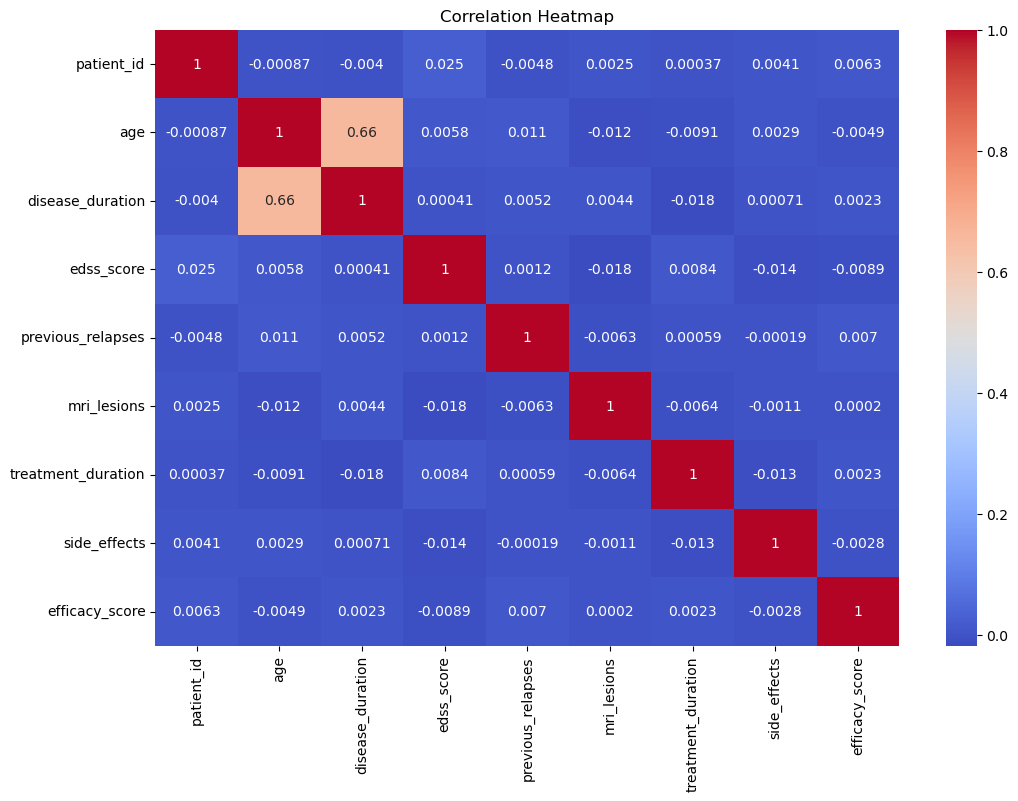

In [8]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

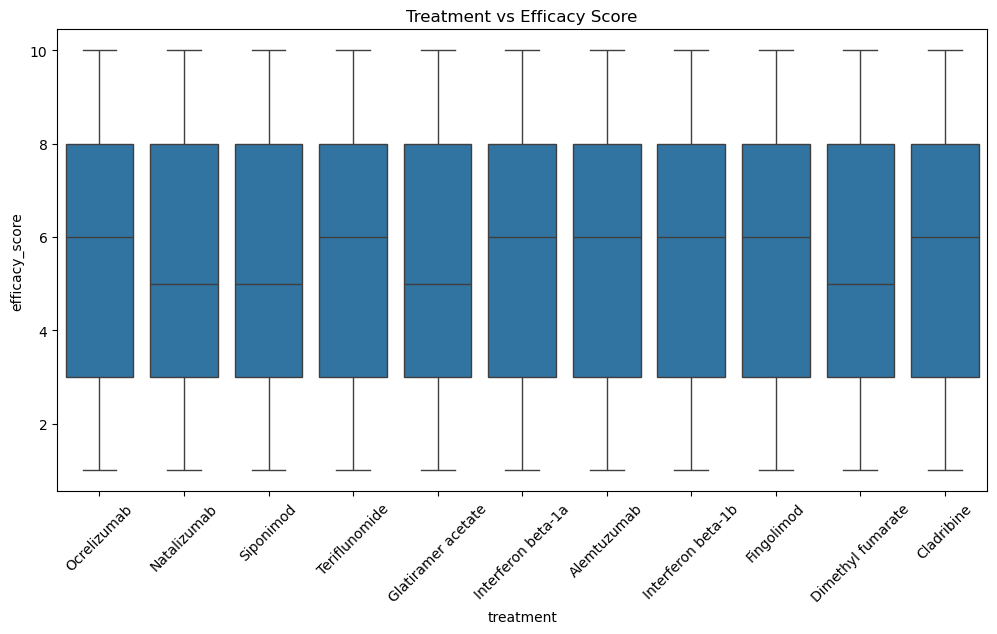

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='treatment', y='efficacy_score', data=df)
plt.title('Treatment vs Efficacy Score')
plt.xticks(rotation=45)
plt.show()

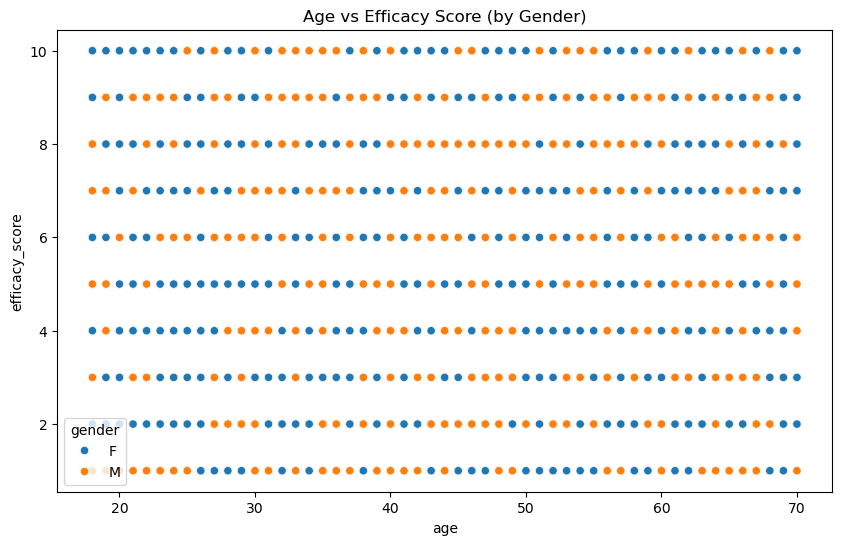

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='efficacy_score', hue='gender', data=df)
plt.title('Age vs Efficacy Score (by Gender)')
plt.show()

In [11]:
df['efficacy_category'] = pd.cut(df['efficacy_score'], 
                                 bins=[0, 3, 7, 10], 
                                 labels=['Poor', 'Moderate', 'Good'])

In [12]:
X = df.drop(['patient_id', 'efficacy_score', 'efficacy_category'], axis=1)
y = df['efficacy_category']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
numeric_features = ['age', 'disease_duration', 'edss_score', 'previous_relapses', 
                    'mri_lesions', 'treatment_duration', 'side_effects']
categorical_features = ['gender', 'treatment']

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [16]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    results[name] = scores.mean()
    
    print(f"{name} - Mean Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Random Forest - Mean Accuracy: 0.3589 (+/- 0.0196)
Gradient Boosting - Mean Accuracy: 0.3786 (+/- 0.0053)
SVM - Mean Accuracy: 0.3935 (+/- 0.0089)


In [18]:
best_model = RandomForestClassifier(random_state=42)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])

In [19]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

In [20]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'disease_duration',
                                                                          'edss_score',
                                                                          'previous_relapses',
                                                                          'mri_lesions',
                                                                          'treatment_duration',
                                                                          'side_effects']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['gender',
                                                                          'treatment'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [21]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Best cross-validation score: 0.39237500000000003


In [22]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [23]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.399

Classification Report:
              precision    recall  f1-score   support

        Good       0.19      0.02      0.03       607
    Moderate       0.41      0.95      0.57       817
        Poor       0.28      0.02      0.04       576

    accuracy                           0.40      2000
   macro avg       0.29      0.33      0.22      2000
weighted avg       0.31      0.40      0.26      2000



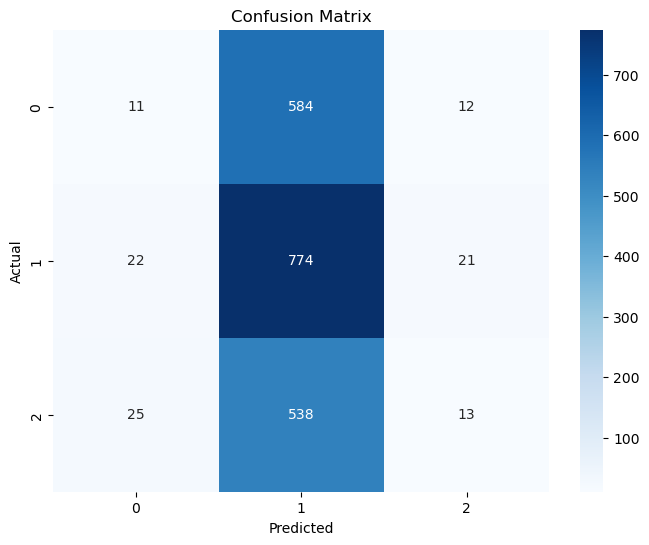

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

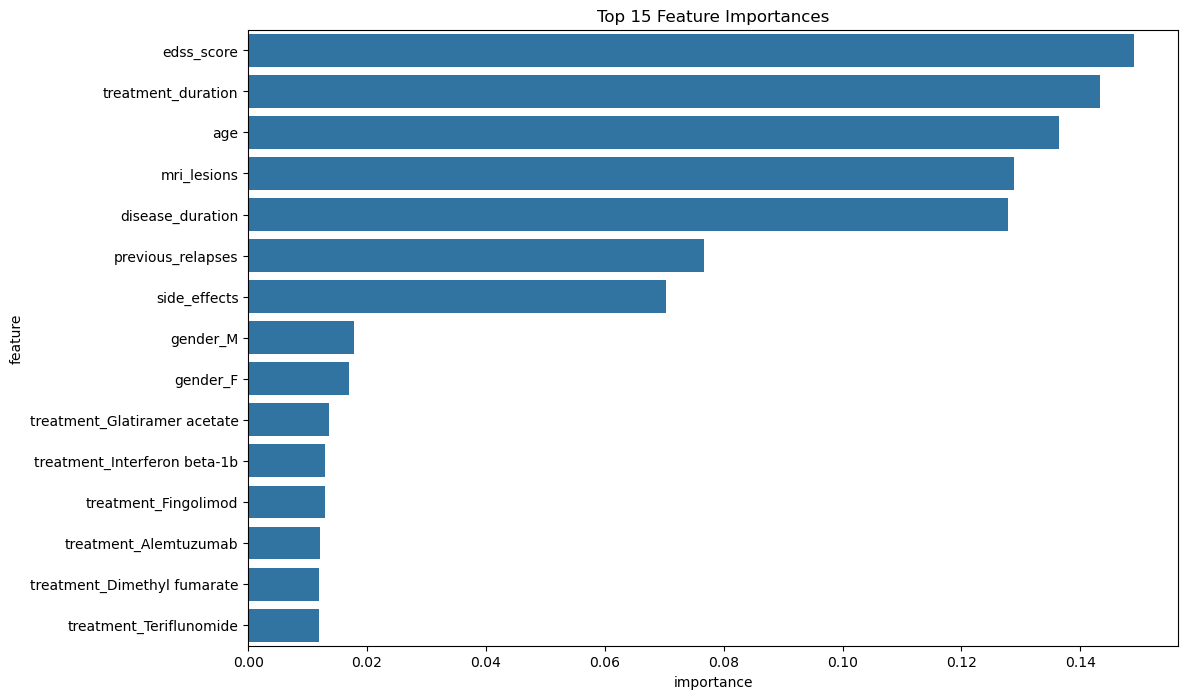

In [26]:
feature_importance = best_model.named_steps['classifier'].feature_importances_
feature_names = (numeric_features + 
                 list(best_model.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .get_feature_names_out(categorical_features)))

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.show()

In [27]:
with open('ms_treatment_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Model exported as 'ms_treatment_model.pkl'")

Model exported as 'ms_treatment_model.pkl'
